In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report




In [2]:
df = pd.read_csv('datapourprediction.csv')

In [3]:
df.shape

(720, 8)

In [12]:
df = df[~df.isin(['75-78']).any(axis=1)]
df = df[~df.isin(['64-75']).any(axis=1)]


Distribution initiale des classes : Counter({-1: 573, 1: 16, 2: 14, 0: 11})
Distribution après SMOTE : Counter({-1: 573, 0: 573, 1: 573, 2: 573})
Rapport de classification :
              precision    recall  f1-score   support

          -1       0.93      0.91      0.92       122
           0       0.90      0.96      0.93       106
           1       0.96      0.95      0.95       115
           2       0.95      0.91      0.93       116

    accuracy                           0.93       459
   macro avg       0.93      0.93      0.93       459
weighted avg       0.93      0.93      0.93       459



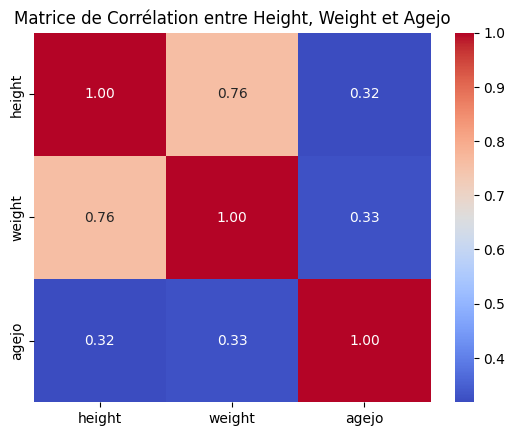

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

<Figure size 1200x800 with 0 Axes>

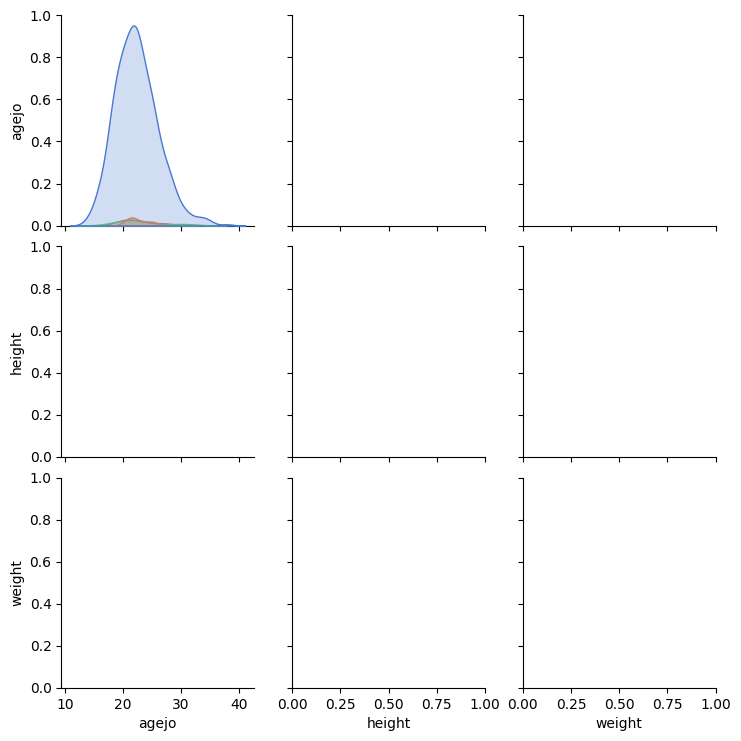

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter


# Encoder la colonne 'medal' en valeurs numériques
df['medal_encoded'] = df['Medal'].map({'Gold': 2, 'Silver': 1, 'Bronze': 0, 'Nothing': -1})

# Calculer l'âge
df['age2028'] = 2028 - df['born']


# Nettoyer les données (supprimer les lignes avec des valeurs manquantes)
df_cleaned = df.dropna(subset=['agejo', 'height', 'weight', 'medal_encoded'])

# Sélectionner les features (X) et la target (y)
X = df_cleaned[['agejo', 'height', 'weight']]
y = df_cleaned['medal_encoded']


# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Vérifier la distribution des classes
print("Distribution initiale des classes :", Counter(y))

# Appliquer SMOTE pour équilibrer les classes
# Ajuster k_neighbors pour ne pas dépasser le nombre d'échantillons dans la classe minoritaire
k_neighbors = min(5, len(np.unique(y)))  # Assurez-vous que k_neighbors ne dépasse pas le nombre d'échantillons
sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_res, y_res = sm.fit_resample(X_scaled, y)

# Vérifier la nouvelle distribution des classes
print("Distribution après SMOTE :", Counter(y_res))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Entraîner le modèle RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Évaluer le modèle sur l'ensemble de test
y_pred = model.predict(X_test)
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# Prédictions pour 2028
X_2028 = df_cleaned[['agejo', 'height', 'weight']].copy()
X_2028['agejo'] = df_cleaned['age2028']  # Remplace l'âge actuel par 'age2028'

corr_matrix = df[['height', 'weight', 'agejo']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de Corrélation entre Height, Weight et Agejo")
plt.show()
# Normaliser les données pour 2028
X_2028_scaled = scaler.transform(X_2028)

# Prédire les résultats des médailles pour 2028
predictions_2028 = model.predict(X_2028_scaled)

# Obtenir les probabilités pour chaque classe
probs_2028 = model.predict_proba(X_2028_scaled)

# Mapper les prédictions en noms de médailles
medal_mapping = {2: 'Gold', 1: 'Silver', 0: 'Bronze', -1: 'Nothing'}
df_cleaned['medal_prediction_2028'] = [medal_mapping[p] for p in predictions_2028]

# Ajouter les probabilités à chaque prédiction
labels = ['Nothing', 'Bronze', 'Silver', 'Gold']
for i, label in enumerate(labels):
    df_cleaned[f'prob_2028_{label.lower()}'] = probs_2028[:, i] * 100  # En pourcentage

# Colonnes des résultats finaux pour chaque joueur unique
result_columns = ['name', 'agejo', 'height', 'weight', 'age2028', 'medal_prediction_2028'] + \
                 [f'prob_2028_{label.lower()}' for label in labels]

# Afficher les prédictions pour 2028
predictions_2028 = df_cleaned[result_columns]

# Enregistrer les prédictions pour 2028 dans un fichier CSV
predictions_2028.to_csv('predictions_2028.csv', index=False)

# Calculer le total des médailles pour chaque joueur
medal_totals = df_cleaned.groupby('name')['Medal'].value_counts().unstack(fill_value=0)

# --- Courbes et Graphiques ---

# Graphiques des relations entre âge, taille, poids et médaille
plt.figure(figsize=(12, 8))

# Tracer les relations
sns.pairplot(df, vars=['agejo', 'height', 'weight'], hue='Medal', palette='muted')
plt.suptitle("Relations entre âge, taille, poids et médaille", y=1.02)
plt.show()

# --- Importance des Caractéristiques ---

# Calculer l'importance des caractéristiques du modèle
feature_importances = model.feature_importances_

# Visualiser l'importance des caractéristiques
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=X.columns)
plt.title('Importance des caractéristiques')
plt.show()

# --- Courbe ROC ---
# Binarisation des classes pour la courbe ROC
y_bin = label_binarize(y_test, classes=[-1, 0, 1, 2])  # Médailles : -1 = Nothing, 0 = Bronze, 1 = Silver, 2 = Gold
n_classes = y_bin.shape[1]

# Calculer les probabilités pour chaque classe
probs = model.predict_proba(X_test)

# Initialiser les dictionnaires pour FPR, TPR et AUC
fpr = {}
tpr = {}
roc_auc = {}

# Calculer les courbes ROC et AUC pour chaque classe
for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la courbe ROC avec des couleurs distinctes et des améliorations
plt.figure(figsize=(10, 8))

colors = ['aqua', 'darkorange', 'green', 'blue']  # Couleurs distinctes pour chaque classe

for i, label in enumerate(labels):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f"{label} (AUC = {roc_auc[i]:.2f})")

# Ajouter la diagonale (référence pour un classificateur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Ajouter les étiquettes et le titre
plt.xlabel('Taux de faux positifs (False Positive Rate)', fontsize=12)
plt.ylabel('Taux de vrais positifs (True Positive Rate)', fontsize=12)
plt.title('Courbes ROC par classe', fontsize=14)
plt.legend(loc="lower right", fontsize=10)

# Ajouter une grille pour améliorer la lisibilité
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()


# Renommer les colonnes pour une meilleure lisibilité
medal_totals = medal_totals.rename(columns={
    'Bronze': 'total_bronze',
    'Silver': 'total_silver',
    'Gold': 'total_gold',
    'Nothing': 'total_nothing'
}).reset_index()

# Ajouter la colonne "total_medals" (somme des médailles Bronze, Silver, Gold)
medal_totals['total_medals'] = medal_totals[['total_bronze', 'total_silver', 'total_gold']].sum(axis=1)

# Joindre les prédictions pour 2028 au tableau des statistiques
final_results = pd.merge(medal_totals,
                         df_cleaned[['name', 'medal_prediction_2028'] + [f'prob_2028_{label.lower()}' for label in labels]].drop_duplicates(subset='name'),
                         on='name',
                         how='left')

# Trier le tableau par "total_medals" en ordre croissant
final_results = final_results.sort_values(by='total_medals', ascending=False)

# Enregistrer les résultats finaux dans un fichier CSV
final_results.to_csv('2028_results.csv', index=False)
print("VOIR LE CSV QUI a été téléchargé")

def predict_for_new_player(name, born, height, weight):
    """
    Prédit les résultats pour un joueur donné en 2028.

    Arguments :
    - name (str) : Nom du joueur
    - born (int) : Année de naissance
    - height (float) : Taille en cm
    - weight (float) : Poids en kg

    Retourne :
    - Un dictionnaire avec les résultats de prédiction.
    """
    # Calculer l'âge actuel et l'âge en 2028
    agejo = 2024 - born  # Par exemple, pour les JO de 2024
    age2028 = 2028 - born

    # Créer le dataframe pour le joueur
    player_data = pd.DataFrame({
        'agejo': [agejo],
        'height': [height],
        'weight': [weight]
    })

    # Normaliser les données
    player_data_scaled = scaler.transform(player_data)

    # Prédire les résultats pour 2028
    prediction = model.predict(player_data_scaled)[0]
    prediction_probs = model.predict_proba(player_data_scaled)[0]

    # Mapper la prédiction et les probabilités en noms de médailles
    medal_prediction = medal_mapping[prediction]
    probabilities = {f"prob_{label.lower()}": round(prob * 100, 2) for label, prob in zip(labels, prediction_probs)}

    # Retourner les résultats
    result = {
        'name': name,
        'agejo': agejo,
        'age2028': age2028,
        'height': height,
        'weight': weight,
        'medal_prediction_2028': medal_prediction,
        **probabilities
    }
    return result


# Afficher les résultats
print("Résultats pour le joueur ajouté :")
for key, value in new_player.items():
    print(f"{key}: {value}")


In [14]:
import pickle

# Enregistrer le modèle RandomForest
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Enregistrer le scaler StandardScaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Modèle et scaler enregistrés avec succès dans 'model.pkl' et 'scaler.pkl'")


Modèle et scaler enregistrés avec succès dans 'model.pkl' et 'scaler.pkl'
